# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline


## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [3]:
# your code here
bike_df=pd.read_csv('data/BSS_hour_raw.csv')


In [4]:
# your code here
bike_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [5]:
bike_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [6]:
# your code here
bike_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


*Your answer here*


#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [7]:
# your code here
from datetime import datetime
from dateutil import parser
bike_df['dteday']=bike_df['dteday'].map(lambda x: parser.parse(x))


In [8]:
bike_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

In [9]:
bike_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [10]:
# your code here
bike_df['year']=[0 if bike_df['dteday'][i].year==2011 else 1 for i in range(bike_df.shape[0])]

In [11]:
# your code here
bike_df['month']= bike_df['dteday'].map(lambda x:x.month)

In [12]:
# your code here
bike_df['counts']=bike_df.casual+bike_df.registered

bike_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,0.502561,6.537775,189.463088
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,0.500008,3.438776,181.387599
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,0.000000,4.000000,40.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,1.000000,7.000000,142.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,1.000000,10.000000,281.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,1.000000,12.000000,977.000000


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

In [13]:
np.random.choice?

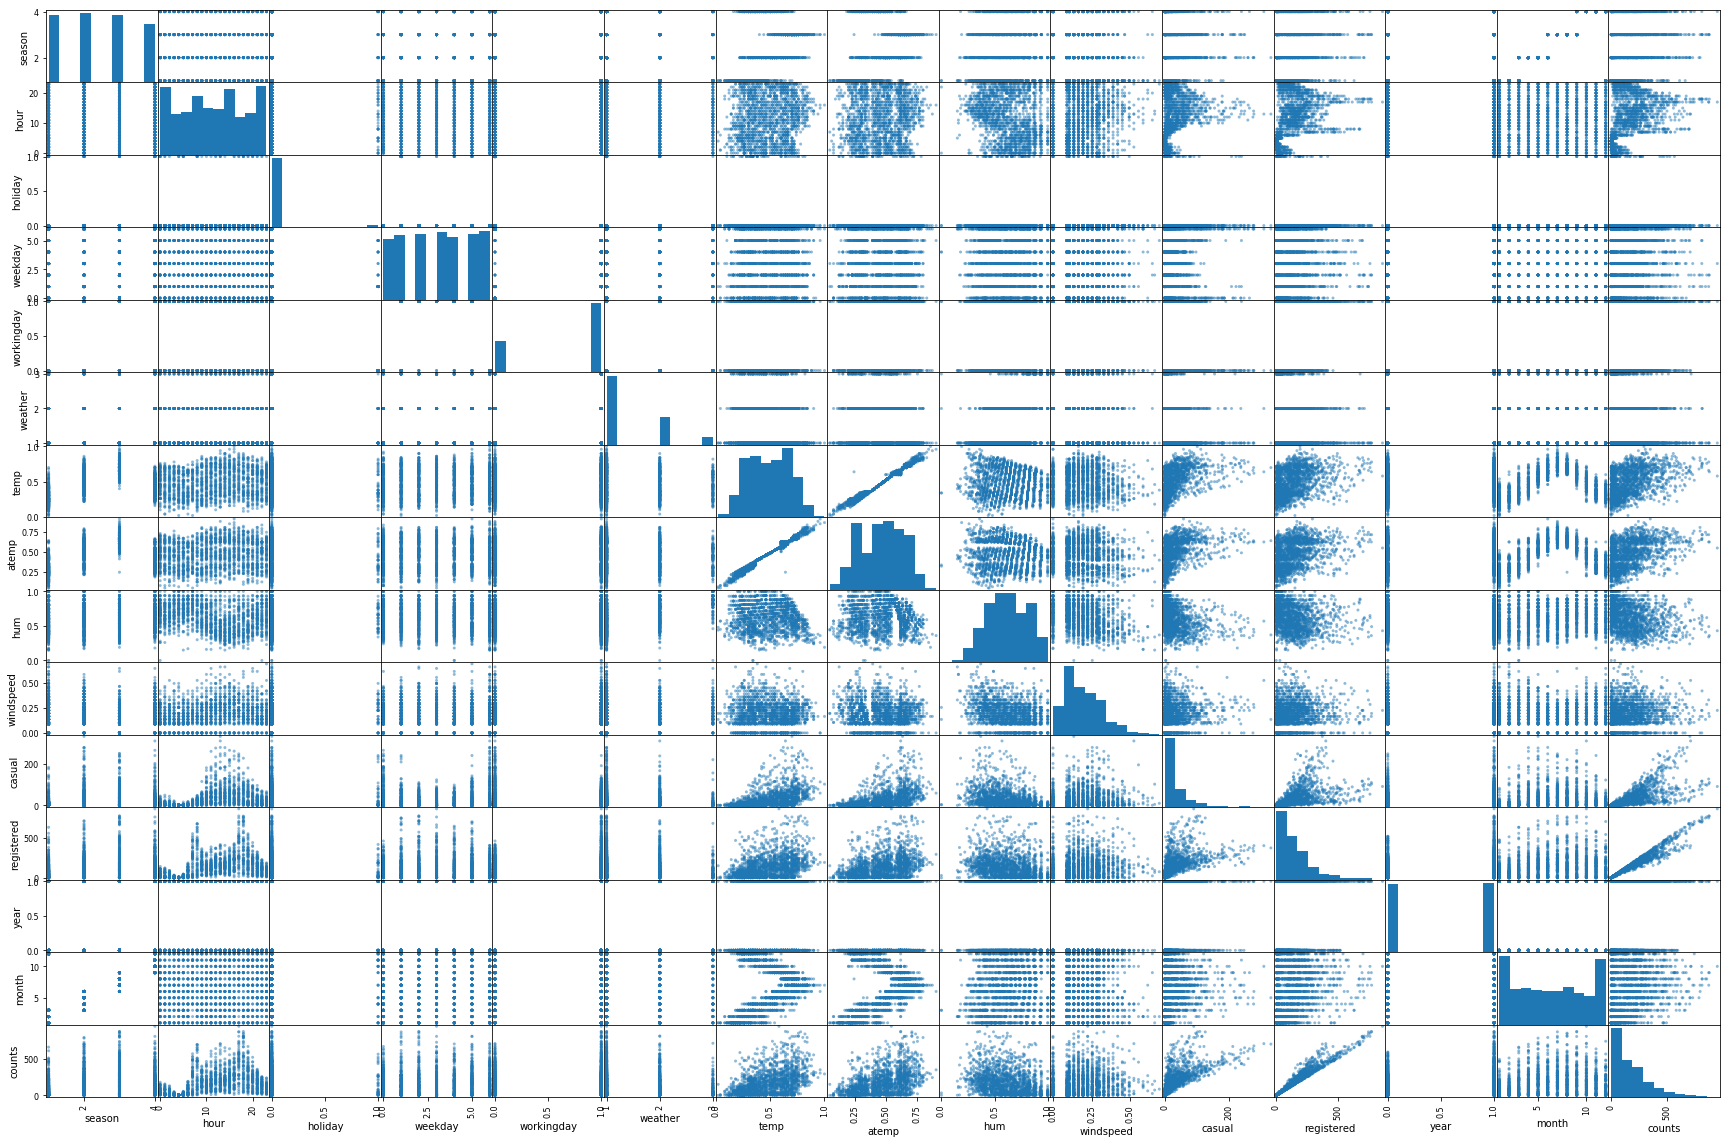

In [14]:
# your code here
from pandas.plotting import scatter_matrix
indexes=np.sort(np.random.choice(int(bike_df.shape[0]),size=int(bike_df.shape[0]/10),replace=False))
sample_bike_df=bike_df.iloc[indexes,:]
scatter_matrix(sample_bike_df,figsize=(30,20))
plt.show()

*your answer here* 


#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

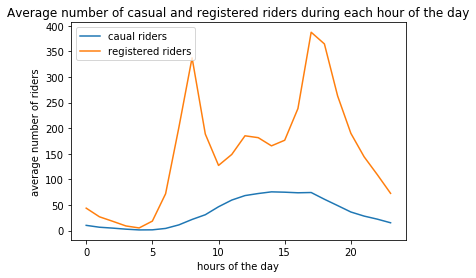

In [13]:
# your code here
hours_of_day=np.arange(24)
groupby_df=bike_df.groupby('hour').aggregate({'casual':np.mean,'registered':np.mean})
plt.plot(hours_of_day,groupby_df.casual,label='caual riders')
plt.plot(hours_of_day,groupby_df.registered,label='registered riders')
plt.xlabel('hours of the day')
plt.ylabel('average number of riders')
plt.legend()
plt.title('Average number of casual and registered riders during each hour of the day')
plt.show()

*your answer here*


#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [14]:
# firstly, average riders by just weather 
by_weather=bike_df.groupby('weather')['counts'].mean()
by_weather

weather
1    204.869272
2    175.165493
3    111.579281
4     74.333333
Name: counts, dtype: float64

In [15]:
bike_df[bike_df.weather==4]

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
585,2011-01-26,1,16,0,3,1,4,0.22,0.1970,0.93,0.3284,1,35,0,1,36
8854,2012-01-09,1,18,0,1,1,4,0.20,0.2273,0.86,0.0896,6,158,1,1,164
9123,2012-01-21,1,1,0,6,0,4,0.14,0.1364,0.86,0.1940,1,22,1,1,23


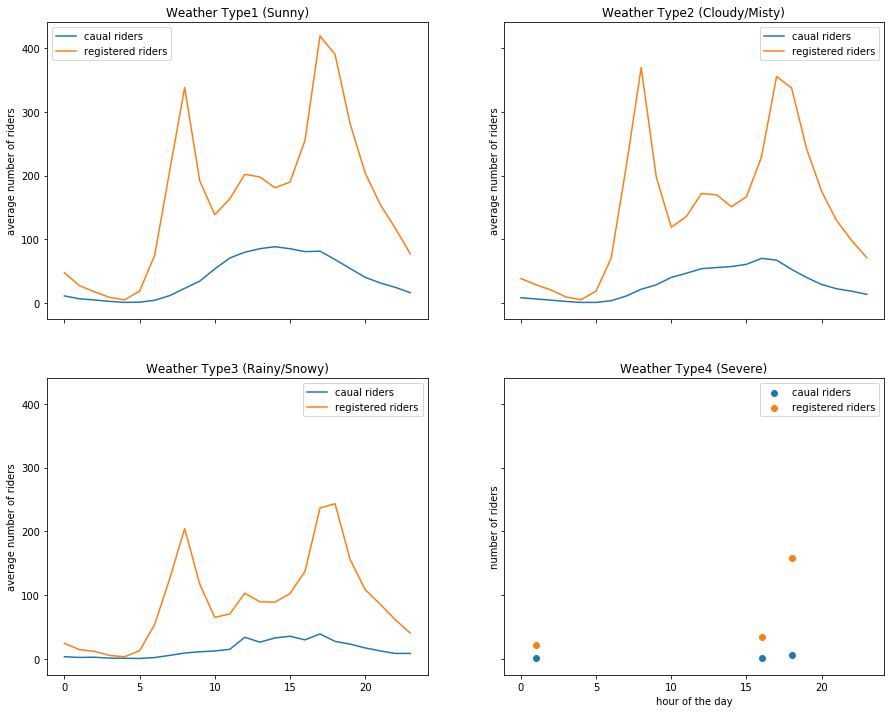

In [16]:
weather_list=['Sunny','Cloudy/Misty','Rainy/Snowy','Severe']
fig,ax=plt.subplots(2,2,figsize=(15,12),sharex='col',sharey=True)
ax = ax.ravel()

for i in range(1,5):
    if i==4:
        data=bike_df[bike_df.weather==i]
        ax[i-1].scatter(data.hour,data.casual,label='caual riders')
        ax[i-1].scatter(data.hour,data.registered,label='registered riders')
        ax[i-1].set_ylabel('number of riders')  
        ax[i-1].set_xlabel('hour of the day')
                    
    else:
        mean_data=bike_df[bike_df.weather==i].groupby('hour').aggregate({'casual':np.mean,'registered':np.mean})
        ax[i-1].plot(hours_of_day,mean_data.casual,label='caual riders')
        ax[i-1].plot(hours_of_day,mean_data.registered,label='registered riders')
        ax[i-1].set_ylabel('average number of riders')
    
    ax[i-1].legend()
    ax[i-1].set_title('Weather Type{} '.format(i)+"("+weather_list[i-1]+")")
    

*your answer here*


In [17]:
bike_df.head(10)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0,1,1
5,2011-01-01,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,0,1,1
6,2011-01-01,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,0,1,2
7,2011-01-01,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,0,1,3
8,2011-01-01,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,0,1,8
9,2011-01-01,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,0,1,14


#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.


In [18]:
# your code here
by_day=bike_df.groupby('dteday').aggregate({'weekday':np.max,'weather':np.max,'season':np.max,'temp':np.mean,'atemp':np.mean,'windspeed':np.mean,'hum':np.mean,'casual':np.sum,'registered':np.sum})
by_day=by_day.reset_index()
by_day['counts']=by_day['casual']+by_day['registered']
bikes_by_day=by_day


#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

Text(0.5,0,'')

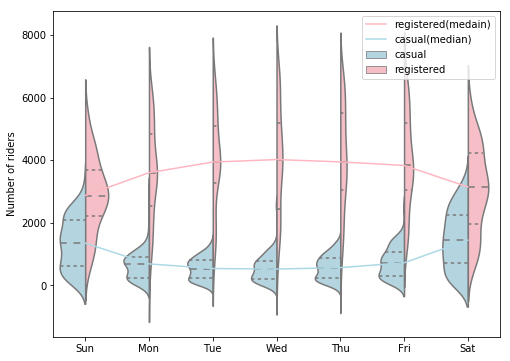

In [79]:
weekday=bikes_by_day.weekday
bike_by_day_sub=bikes_by_day[['casual','registered']]
rider_number=bike_by_day_sub.stack().values
rider_type=['casual','registered'] * int(len(rider_val)/2)
weekday_sub=bikes_by_day[['weekday','weekday']]
weekday=weekday_sub.stack().values
bike_df_sub=pd.DataFrame({'weekday':weekday,'rider_number':rider_number,'rider_type':rider_type})
fig=plt.figure(figsize=(8,6))
sns.violinplot("weekday",'rider_number',hue='rider_type',data=bike_df_sub,split=True,inner='quartile',palette=['lightblue','lightpink'])
weekdays=['Sun','Mon',  'Tue',  'Wed',
        'Thu', 'Fri','Sat']
#plot median
meds=bikes_by_day.groupby('weekday')[["registered","casual"]].median()
plt.plot(np.arange(7),meds['registered'],label='registered(medain)',color='lightpink')
plt.plot(np.arange(7),meds['casual'],label='casual(median)',color='lightblue')
plt.legend()
plt.xticks(np.arange(7),weekdays)
plt.ylabel('Number of riders')
plt.xlabel('')


 What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

In [84]:
by_day_sum=bikes_by_day.groupby('weekday')[['casual','registered','counts']].sum()
by_day_sum['percentage of casual']=by_day_sum.casual/by_day_sum.counts
by_day_sum.index=weekdays
by_day_sum

,casual,registered,counts,percentage of casual
Sun,140521,303506,444027,0.316469
Mon,70784,384719,455503,0.155397
Tue,57843,411266,469109,0.123304
Wed,57319,415729,473048,0.121170
Thu,61460,423935,485395,0.126619
Fri,78238,409552,487790,0.160393
Sat,153852,323955,477807,0.321996


#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 


**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

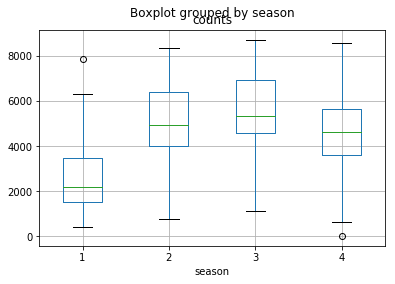

In [85]:
# your code here
bikes_by_day.boxplot('counts',by='season');

In [21]:
# your code here


In [22]:
# your code here 


*your answer here* 


<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [24]:
#your code here

#save the pre-recoding bikes data
bikes_df_copy = bikes_df.copy(deep=True)
bikes_df.head()

In [25]:
#your code here
categorical_columns = ['season', 'month', 'holiday', 'weekday', 'workingday', 'weather']
categorical_columns_dummy = ['season', 'month', 'weekday', 'weather']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']

bikes_df = pd.get_dummies(bikes_df_copy, columns=categorical_columns_dummy, drop_first=True)

In [26]:
#your code here

bikes_df.columns

In [27]:
#your code here


In [28]:
#your code here


####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [ ]:
# your code here
train_df

In [ ]:
# your code here


*your answer here*


#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [ ]:
# your code here
bikes_train = pd.read_csv('data/BSS_train.csv', index_col=0).reset_index(drop=True)
bikes_train = bikes_train.drop(['dteday','casual','registered'], axis=1)

bikes_test = pd.read_csv('data/BSS_test.csv', index_col=0).reset_index(drop=True)
bikes_test = bikes_test.drop(['dteday','casual','registered'], axis=1)


In [ ]:
# your code here
bikes_test.head(10)

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [ ]:
# your code here
x_train=bikes_train.drop('counts',axis=1)
x_test=bikes_test.drop('counts',axis=1)
X_train=sm.add_constant(x_train)
X_test=X=sm.add_constant(x_test)

In [ ]:
# your code here
model=sm.OLS(bikes_train['counts'],X_train)
results_train=model.fit()
pred_value_train=train_results.predict(X_train)
pred_value_test=train_results.predict(X_test)
print("train R2 value:" ,results_train.rsquared)
print("test R2 value:" ,r2_score(bikes_test['counts'],pred_value_test))

#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [ ]:
results_train.summary()

In [ ]:
# your code here
results_train.pvalues[train_results.pvalues<0.05].index

*your answer here*


#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

In [ ]:
# your code here
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[1].hist(bikes_test['counts']-pred_value_test)
ax[1].set_xlabel("residuals")
ax[1].set_ylabel("Frequencies")
ax[1].set_title('Residual histogram for test data')
ax[0].hist(bikes_train['counts']-pred_value_train)
ax[0].set_xlabel("residuals")
ax[0].set_ylabel("Frequencies")
ax[0].set_title('Residual histogram for train data')


In [ ]:
plt.scatter(pred_value_test,bikes_test['counts']-pred_value_test,alpha=0.1,marker='.',color='blue')
plt.scatter(pred_value_train,bikes_train['counts']-pred_value_train,alpha=0.3,marker='.',color='green')
plt.hlines(y = 0, xmin=-200, xmax = 500,color='y')
plt.xlabel('predicted value')
plt.ylabel('residuals')
plt.scatter(pred_value_test,bikes_test['counts']-pred_value_test,alpha=0.5)


*your answer here* 


#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [ ]:
train_X_poly=train_X.copy()
train_X_poly['temp2']=train_X.temp**2
train_X_poly['hour2']=train_X.hum**2
train_X_poly['hum2']=train_x.hum**2

*your answer here*


#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [ ]:
# your code here


*your answer here*


<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [ ]:
# your code here


In [ ]:
# your code here


#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

*your answer here*


#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [ ]:
# your code here


*your answer here*


#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




*your answer here*


In [ ]:
# your code here


*your answer here* 


In [ ]:
#your code here


*your answer here* 
